# Task 1 - Context

In [98]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import random
from tqdm import tqdm
import time
import seaborn as sns
from scipy.stats import zscore
from adjustText import adjust_text
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import combinations
from collections import defaultdict
from community import community_louvain
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)



# Task 2 - The Data

## Dataset information

[Arxiv GR-QC](https://snap.stanford.edu/data/ca-GrQc.html) (General Relativity and Quantum Cosmology) collaboration network is from the e-print arXiv and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. 

## Nodes and Edges
If an author **i** co-authored a paper with author **j**, the graph contains a undirected edge from **i** to **j**. If the paper is co-authored by **k** authors this generates a completely connected (sub)graph on **k** nodes.

**Nodes:** 

Represent individual authors who have contributed to papers in the General Relativity and Quantum Cosmology (GR-QC) section of arXiv.

**Edges:**

Edges are undirected and represent co-authorship between authors:
If two authors, i and j, co-authored at least one paper together, there is an edge connecting i and j.
If a paper is co-authored by k authors, it generates a fully connected subgraph (a complete graph) of k nodes, meaning every pair of authors is directly connected by an edge.

The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv, and thus represents essentially the complete history of its GR-QC section


## Task
- Explain the dataset itself (e.g., what do the nodes and edges represent?).
- Explain how the dataset is suitable for the project from Task 1. Show a helpful visualization of
(part of) to support your explanation.

In [2]:
file_path = Path(os.path.join('..', 'data', 'ca-GrQc.txt', 'CA-GrQc.txt'))

df_graph = pd.read_csv(filepath_or_buffer=file_path, header=None, names=['from', 'to'], sep='\t', skiprows=4)
display(df_graph.head())


from     to
0  3466    937
1  3466   5233
2  3466   8579
3  3466  10310
4  3466  15931

# Task 3 – IDA and Preprocessing

In [3]:
G = nx.from_pandas_edgelist(df=df_graph, source='from', target='to')

print(f'Number of Edges: {G.size()}')
print(f'Number of Nodes: {G.order()}')

Number of Edges: 14496
Number of Nodes: 5242


## Handshaking Lemma
The Handshaking Lemma is a fundamental rule which states for undirected graphs. 
The sum of the degree of all vertices in an undirected graph is equal to twice the number of edges.

$\sum_{v \in V} \deg(v) = 2 \cdot |E|$

The following code checks whether the graph is undirected by applying the Handshaking Lemma.

For this we first bring the graph `G` into the Adjacency Matrix


In [4]:
def handshake_lemma(G):

    A = nx.adjacency_matrix(G)

    print(f'Adjacency Matrix shape: \n{A.shape}\n')

    print(f'Sum of the Degrees:\n{A.sum()}\n') # Summing up the degree

    if A.sum() == 2*G.size():
        print('The Handshake Lemma holds')
    else:
        print('The Handshake Lemma does not hold ')
        print(f'Difference: {A.sum() - 2*G.size()}')


handshake_lemma(G)


Adjacency Matrix shape: 
(5242, 5242)

Sum of the Degrees:
28980

The Handshake Lemma does not hold 
Difference: -12


<div class="alert alert-block alert-info">

As we can see that Handshake Lemma does not hold by a number of 12 edges. 

Next we want to investigate further why this is so.

</div>

## Basic Properties 



### First Look at the Graph

In [5]:
def get_pos(G):
    k = 1 /  np.sqrt(G.number_of_nodes()) # Standard distance between nodes
    pos = nx.spring_layout(G, seed=42,k=k+0.06) # set k higher to spread out the nodes more
    return pos

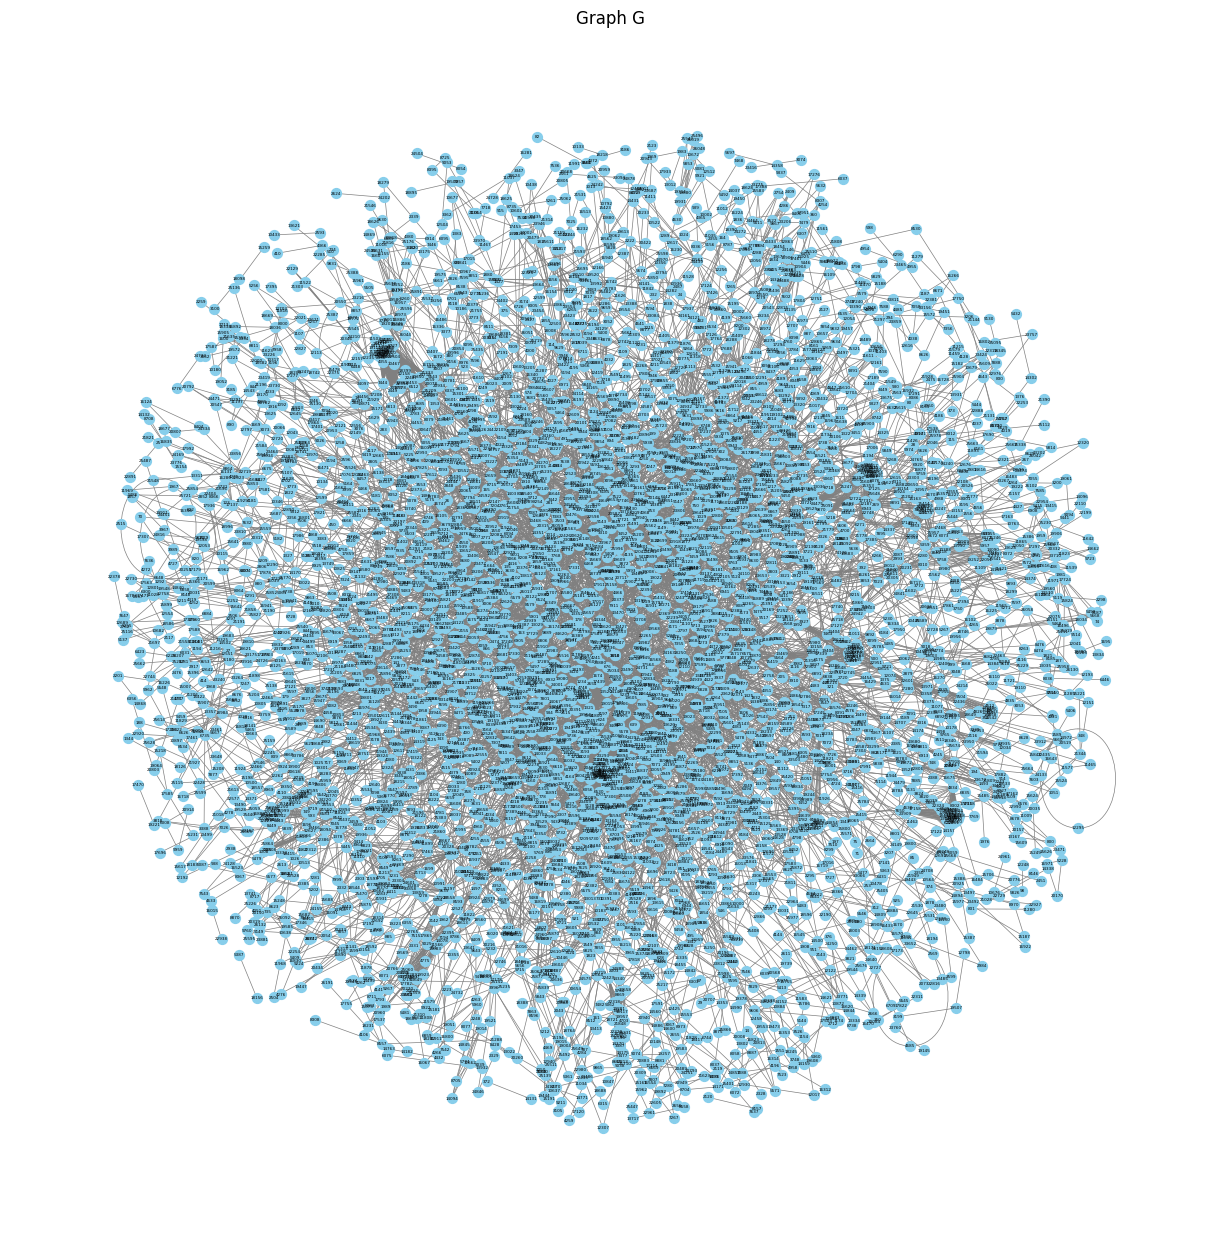

In [6]:
# set global sizes
NODE_SIZE = 50
EDGE_WIDTH = 0.5
FONT_SIZE = 3
EDGE_COLOR_STANDARD = 'gray'
NODE_COLOR_STANDARD = 'skyblue'

# draw Grpah
plt.figure(figsize=(12, 12))
pos = get_pos(G)

nx.draw(
    G, 
    pos=pos, 
    with_labels=True, 
    node_color=NODE_COLOR_STANDARD, 
    node_size=NODE_SIZE, 
    edge_color=EDGE_COLOR_STANDARD, 
    width=EDGE_WIDTH,  
    font_size=FONT_SIZE
)


plt.title(label="Graph G")
plt.show()



In [7]:
# Show self loop edges
self_loop_list = list(nx.selfloop_edges(G))
print(f'Number of self loop edges: {len(self_loop_list)}')

Number of self loop edges: 12


<div class="alert alert-block alert-info">

**Observations:**

- We can observe from plotting the colaboration network, that 12 authors co-authored with themselfes.
- The central part of the network appears to be highly dense, indicating a group of authors who frequently collaborate with one another. These are likely well-connected or prolific authors in the field.
- The outer regions of the network contain many sparsely connected nodes, representing authors with fewer collaborations or those who only co-authored with a small group.
- Several smaller clusters can be seen in the network. These might represent subfields or independent collaboration groups that are disconnected from the main network.

**Hypotheses about the selfloops:** 

- The dataset might have been constructed in a way that includes every author as co-author of their own works.
- There might be duplicate entries in the dataset where an author is listed multiple times for the same paper or mistakenly added as their own co-author.

**Further steps:**

In the preprocessing step we will delete those nodes from the network.

</div>

### Degree Distribution
The degree distribution show the frequency of degrees. How often occurs a number of degrees of a graph. 

### CCRF
The Complementary Cumulative Relative Frequency (CCRF) of Degrees is a statistical representation that shows the proportion of nodes in a graph whose degree is greater than or equal to a given value.

In [8]:
def basic_graph_properties(G):


    graph_properties = {
        'Number of nodes': G.number_of_nodes(),
        'Number of edges': G.number_of_edges(),
        'Sum of degrees': sum(dict(G.degree()).values()),
        "Node with highest degree": max(dict(G.degree()), key=lambda x: G.degree[x]),
        "Node with highest betweenness": max(nx.betweenness_centrality(G).items(), key=lambda x: x[1])[0],
        'Density': nx.density(G),
        'Is undirected graph': not nx.is_directed(G),
        'Is connected':nx.is_connected(G)
    }

    if not nx.is_directed(G):
        graph_properties['Number of connected components'] = nx.number_connected_components(G)
        largest_cc = max(nx.connected_components(G), key=len)
        graph_properties['Size of largest connected component'] = len(largest_cc)

    graph_properties['Average cluster coefficient'] = nx.average_clustering(G)
    return graph_properties



In [9]:
def degree_distribution(G):
    

    # Degree distribution
    degrees = [d for _, d in G.degree()]
    #degree_hist = np.histogram(degrees, bins=range(min(degrees), max(degrees) + 1))

    # CCDF
    degree_counts = np.bincount(degrees)
    ccdf = 1.0 - np.cumsum(degree_counts) / sum(degree_counts)

    # Plot
    plt.figure(figsize=(12, 6))

    # Degree Distribution
    plt.subplot(1, 2, 1)
    plt.hist(degrees, bins=30, edgecolor="k")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree Distribution")

    # CCDF
    plt.subplot(1, 2, 2)
    plt.plot(range(len(ccdf)), ccdf, marker="o", linestyle="none")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("CCDF (log scale)")
    plt.title("Complementary Cumulative Distribution Function")

    plt.tight_layout()
    plt.show()


Degree Distribution before preprocessing:



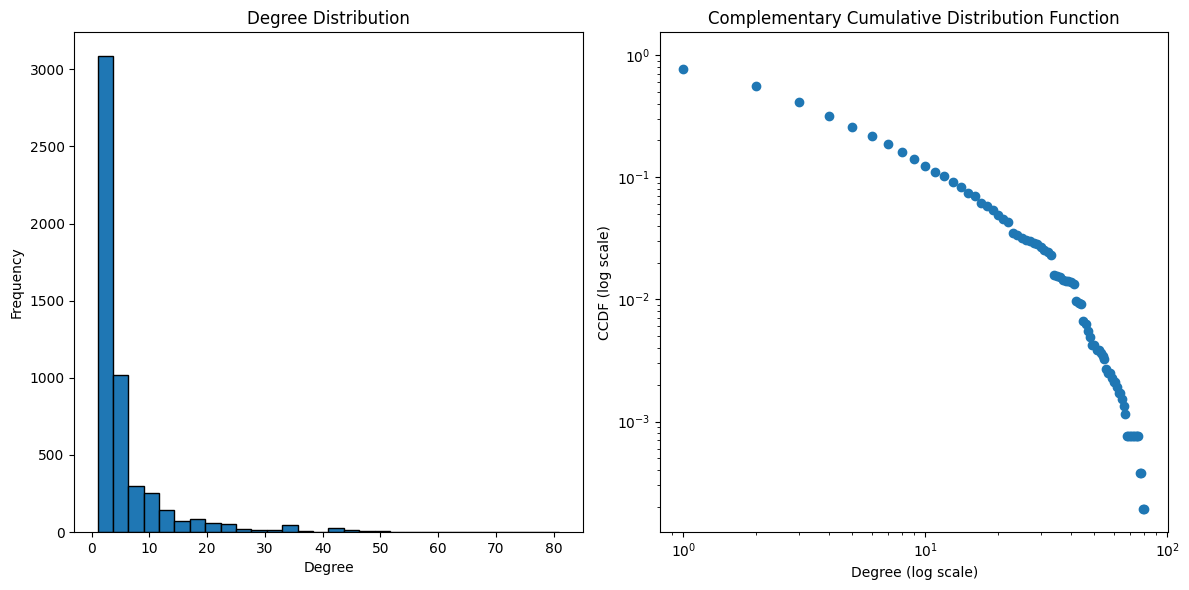

Degree Distribution after preprocessing:



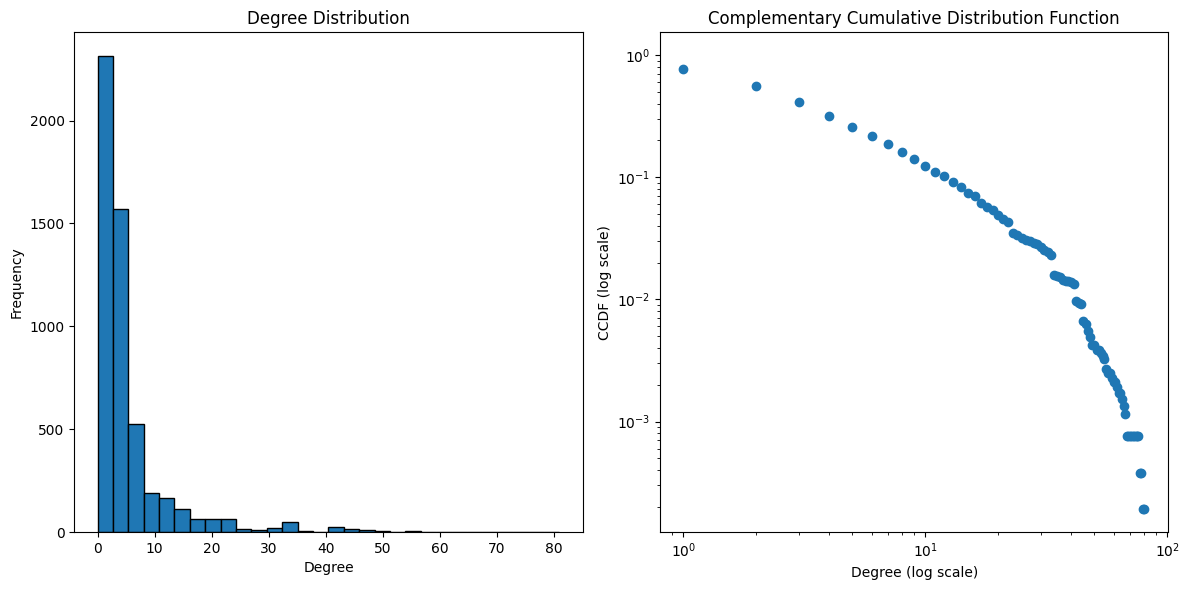

Before Processing After Processing
Number of nodes                                  5242             5242
Number of edges                                 14496            14484
Sum of degrees                                  28992            28968
Node with highest degree                        21012            21012
Node with highest betweenness                   13801            13801
Density                                      0.001055         0.001054
Is undirected graph                              True             True
Is connected                                    False            False
Number of connected components                    355              355
Size of largest connected component              4158             4158
Average cluster coefficient                  0.529636         0.529636

Adjacency Matrix shape: 
(5242, 5242)

Sum of the Degrees:
28968

The Handshake Lemma holds


In [10]:
def preprocessing(G):
    G = nx.Graph(G)  # Ensure that a deep copy of G is created
    G.remove_edges_from(nx.selfloop_edges(G=G))  # Remove self-loops
    return G

G_new = preprocessing(G=G)


print("Degree Distribution before preprocessing:\n")
degree_distribution(G=G)

print("Degree Distribution after preprocessing:\n")
degree_distribution(G=G_new)

display(pd.DataFrame(data={'Before Processing': basic_graph_properties(G=G),
                      'After Processing': basic_graph_properties(G=G_new)}))

handshake_lemma(G=G_new)

# set G_new as G for simplicity for the following analysis
G = G_new.copy() 

<div class="alert alert-block alert-info">

**Degree Distribution:**
- The degree distribution indicates that most authors (nodes) have few collaborations (low degree), while a small number of nodes have many collaborations (high degree).
- Comapred to the other authors, there a few authors (nodes) who calloborated extensively with others. 

**CCDF:**
- the approximately linear decrease on a log-log scale suggests the network's degree distribution follows a power-law. A few researchers dominate collaborations while many have only a few co-authors.
---
This suggest that in the field of General Relativity and Quantum Cosmology are a small amount of authors who play a important role because they are collaborate extensivly more then others.

</div>

### k-Cores

A k-Core in a collaboration network is a subgraph where each node (author) has at least k connections (edges) with other authors (nodes) in the subgraph. With k-cores it is possible to identify zentral nodes and very close interconnected groups in a network.

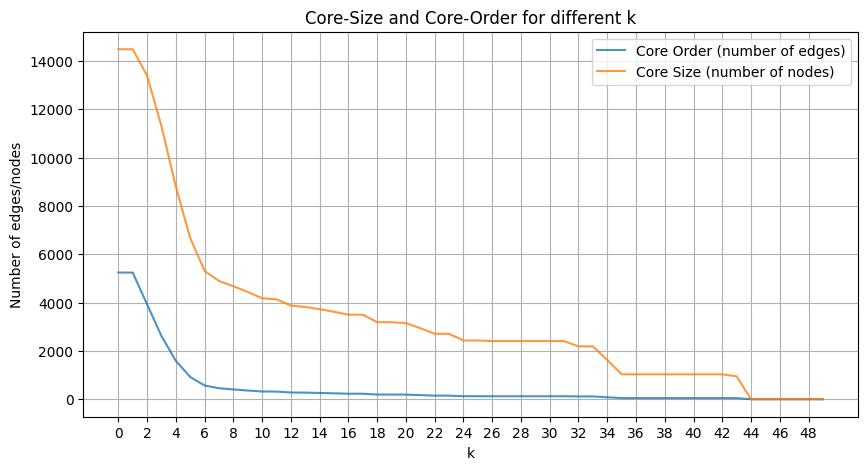

In [11]:
for i in range(0,50):
    if (i%10==0):
        core=nx.k_core(G=G, k=i)



# Listen für die x- und y-Werte
x_values = []
y_values_size = []
y_values_order = []

# Werte berechnen
for i in range(0, 50):
    core = nx.k_core(G=G, k=i)
    x_values.append(i)
    y_values_size.append(core.size())
    y_values_order.append(core.order())
    #print(i, core.size(), core.order())

# Liniendiagramm erstellen
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values_order, label='Core Order (number of edges)', alpha=0.8)
plt.plot(x_values, y_values_size, label='Core Size (number of nodes)', alpha=0.8)

plt.xlabel('k')
plt.ylabel('Number of edges/nodes')
plt.title('Core-Size and Core-Order for different k')
plt.xticks(np.arange(0, 50, 2))
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">

- The sharp decline of the number of edges at low k values indicates that many collaborations in the network involve individuals with only a few connections.
- By k ≈ 10, the number of collaborations becomes much smaller, as most weakly connected authors are removed.
- At very high k values (k > 40), the number of collaborations approaches zero, indicating that the remaining core is extremely small and consists of only the most highly collaborative authors.

- As k increases, the number of collaborators drops sharply, especially up to k ≈ 10. This suggests that only a smaller group of individuals has a significant number of collaborations.
- Beyond k ≈ 20, the decline becomes more gradual, indicating that a highly interconnected "core group" of collaborators remains.
- At k > 40, the number of collaborators approaches zero, meaning very few individuals are part of such high k-Cores, where each individual must have a very large number of collaborations.

- This core group represents the most active and central contributors in the collaboration network, who likely play a key role in sustaining and driving collective work.

</div>

In [12]:


def plot_k_cores_all(G, colormap='Spectral_r'):
    """
    Visualize the k-Cores of a graph G with a continuous colormap.
    Each node is colored based on the k-Core it belongs to.
    """
    # Compute the k-Core value for each node
    core_number = nx.core_number(G)  # Dictionary {node: k-value}
    max_k = max(core_number.values())  # Maximum k-Core value
    
    # Define a colormap (e.g., Viridis)
    cmap = plt.get_cmap(name=colormap, lut=max_k + 1)          
    norm = mcolors.Normalize(vmin=0, vmax=max_k)  # Normalize k-values for colormap

    # Node colors based on k-Core values
    node_colors = [cmap(core_number[node]) for node in G.nodes()]

    # Graph layout
    plt.figure(figsize=(12, 10))
    plt.title("Network Graph Colored by k-Core Values")
    pos = get_pos(G)

    # Draw the graph with continuous k-Core coloring
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,  # Colors from the k-Core colormap
        edge_color=EDGE_COLOR_STANDARD,
        node_size=NODE_SIZE,
        font_size=FONT_SIZE,
        width=EDGE_WIDTH,
        alpha=0.8
    )

    # Add a colorbar using a dummy scatter plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for colorbar
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label("k-Core Value")

    plt.show()

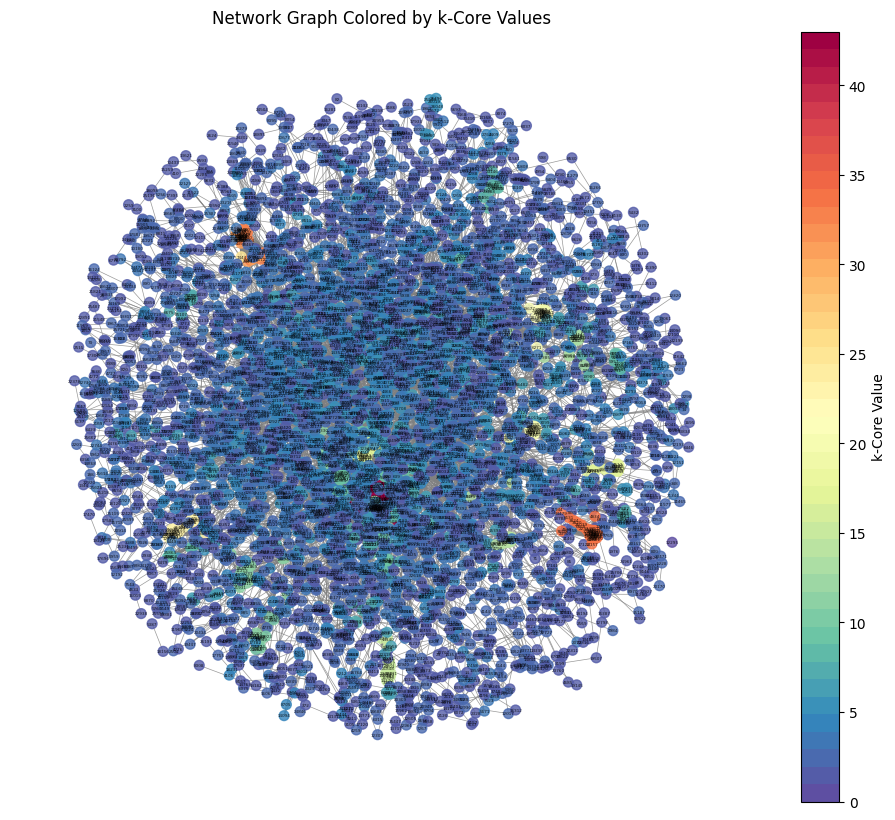

In [13]:
plot_k_cores_all(G)

In [14]:
core_number = nx.core_number(G) 
k_core_df = pd.DataFrame([core_number]).T.rename(columns={0: 'k-core'}).sort_values(by='k-core', ascending=False)
print(f'Nodes with the largest k-cores:')
display(k_core_df.loc[k_core_df['k-core'] == k_core_df['k-core'].max()])


Nodes with the largest k-cores:


k-core
6830       43
17655      43
6610       43
11241      43
20635      43
9785       43
20562      43
19961      43
18894      43
20108      43
17692      43
7956       43
8879       43
12365      43
11472      43
24955      43
25346      43
25758      43
6179       43
773        43
19423      43
21012      43
15003      43
3372       43
4164       43
4513       43
2952       43
12496      43
12781      43
14540      43
12851      43
14807      43
15659      43
45         43
570        43
21508      43
21847      43
22887      43
22691      43
1653       43
2212       43
2741       43
21281      43
23293      43

# Task 4 – Graph Properties

## Explaination




**Average degree:**

Is the average amount of edges on a node  



**Max degree:**

Is the maximal amount of degrees of a node



**Number of connected components:**

This is the total count of such distinct subgraphs in the graph.

- If the graph is fully connected (i.e., there is a path between every pair of nodes), the graph has one connected component.
- If the graph consists of several isolated clusters, the number of connected components is greater than one.



**Transitivity:**

The Transitivity (Global Clustering Coefficient) is defined as the ratio of the number of closed triplets (triangles) to the total number of connected triplets of nodes in the graph. In sozial Networks: How many friends share the same friends as you do.

Let $(a_{a,v})_{u,v \in V}$ be the adjacency matrix of Graph G

transitivity of G is the fraction of closed triplets (3 nodes connected by three edges) among all dyads (three nodes connected by at least two edges)

$$\frac{ \sum_{u,v,w \in V} a_{u,v} a_{v,w} a_{w,u} }{ \sum_{v \in V} deg(v) \cdot (deg(v) - 1) }$$


0: No clustering (no triangles in the graph).

1: Perfect clustering (every possible triplet forms a triangle, as in a complete graph)

---

**Density:**

The [density](https://en.wikipedia.org/wiki/Dense_graph) of an undirected graph measures how "completet" the graph is. Its a measure of how many edges a graph has to the maximum possible number of edges. 
Complete graphs have a density D = 1 and a graph with no edges (empty graph) is D = 0.

Density is defined as:

$$D = \frac{2 \cdot |E|}{|V|(|V|-1)}$$

with:
- |E|: Number of edges
- |V|: Number of Nodes


**Efficiency:**

Is the average of the inverse shortest path lengths between to pairs of nodes. It measures how "efficient" the graph is in terms of connectivity and accessibility.

**Average Cluster Coefficient:**

...

**Assortativity:**

...

Erdős–Rényi random graph model with fix number of nodes and number of edges

In [15]:
def compute_properties(G):
    properties = {
        "Average degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "Max degree": max(dict(G.degree()).values()),
        "Density": nx.density(G),
        "Number of connected components": nx.number_connected_components(G) if not G.is_directed() else "N/A",
        "Efficiency": nx.global_efficiency(G), # Alternative for averagge shortest path legth for unconnected graphs
        "Transitivity": nx.transitivity(G),
        "Average Clustering Coefficient": nx.average_clustering(G),
        "Assortativity": nx.degree_assortativity_coefficient(G),
    }
    return properties


start_time = time.time()
# Properties of G
properties_G = compute_properties(G)
end_time = time.time()
print(f'Time to compute properties for graph G: {end_time - start_time}')

# Erdős–Rényi Random Graphs   
random_properties_list = []

# Compute graph properties for different random Erdős–Rényi graphs with 10 different seeds
for seed in tqdm(range(5)):

    # Probability p for Erdős-Rényi graph based on the density of G
    p = nx.density(G)

    # Random erdos renyi graph
    random_graph = nx.erdos_renyi_graph(n=G.number_of_nodes(), p=p, seed=seed)
    #random_graph = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges(), seed=seed)
    random_properties = compute_properties(random_graph)
    random_properties_list.append(random_properties)  

# Compute averages of random graph properties
random_properties_avg = pd.DataFrame(random_properties_list).mean(numeric_only=True).to_dict()

# Compare properties
comparison = pd.DataFrame({"G Graph": properties_G, "Erdős-Rényi Avg": random_properties_avg})
display(comparison)


Time to compute properties for graph G: 11.86717414855957


100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


G Graph  Erdős-Rényi Avg
Average degree                    5.526135         5.539336
Max degree                       81.000000        16.200000
Density                           0.001054         0.001057
Number of connected components  355.000000        23.600000
Efficiency                        0.112835         0.198680
Transitivity                      0.629842         0.001123
Average Clustering Coefficient    0.529636         0.001106
Assortativity                     0.659325         0.005529

<div class="alert alert-block alert-info">

</div>

# Task 5 – Central Nodes

## Explaination of the Centralities

More information about the centrality measures can be found [here](https://www.sciencedirect.com/topics/computer-science/degree-centrality#:~:text=The%20degree%20centrality%20of%20a,high%20centrality%20by%20other%20measures.).

**Degree Centrality:** 

Measures the importance of a node in a network based on the number of direct connections (edges) it has. It reflects the local influence of a node in the graph by simply counting its neighbors. Higher degree centrality means that the node is more central.

$$
C_d(v) = \frac{deg(v)}{|V| - 1}
$$

where:
- $deg(v)$: Is the number of edges connected to the node $v$
- $|V|: Total number of nodes in the graph$

**Betweenness Centrality:**

Measures the importance of a node by quantifying how often it acts as a bridge along the shortest paths between other nodes in a graph. It identifies nodes that have significant control over the flow of information or resources in the network. High betweenness centrality means that a node is cucial in the connections between many other nodes. Nodes with a high betweenness are often called gate keepers.

$$
C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$

where:
- $\sigma_{st}$: The number of shortest paths from node $s$ to node $t$
- $\sigma_{st}(v)$: The number of shortest paths from node $s$ to node $t$ that pass through node $v$




In [16]:


# Compute the centralities of nodes
centrality_df = pd.DataFrame({
    'Node': list(G.nodes),
    'Degree Centrality': nx.degree_centrality(G).values(),
    'Betweenness Centrality': nx.betweenness_centrality(G).values(),
    'Closeness Centrality': nx.closeness_centrality(G).values(),
    'PageRank': nx.pagerank(G).values()
})


# Calculate the rank of the centralities. Ascending False that the highest centralitie measure has rank 1
centrality_df['Degree Centrality Rank'] = centrality_df['Degree Centrality'].rank(ascending=False)
centrality_df['Betweenness Centrality Rank'] = centrality_df['Betweenness Centrality'].rank(ascending=False)
centrality_df['Closeness Centrality Rank'] = centrality_df['Closeness Centrality'].rank(ascending=False)
centrality_df['PageRank Rank'] = centrality_df['PageRank'].rank(ascending=False)



for col in centrality_df.columns:
    if ' Rank' in col:
        print(f'Top 5 nodes with highest {col}:')
        display(centrality_df.nsmallest(n=5, columns=[col]))



Top 5 nodes with highest Degree Centrality Rank:


Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  \
101  21012           0.015455                0.011649              0.186546   
295  21281           0.015073                0.009643              0.178778   
103  22691           0.014692                0.009777              0.184759   
279  12365           0.014692                0.011229              0.185309   
72    6610           0.012975                0.012767              0.182075   

     PageRank  Degree Centrality Rank  Betweenness Centrality Rank  \
101  0.001070                     1.0                         36.0   
295  0.001153                     2.0                         58.0   
103  0.001082                     3.5                         56.0   
279  0.001035                     3.5                         42.0   
72   0.000909                     5.5                         30.0   

     Closeness Centrality Rank  PageRank Rank  
101                        6.0           10.0  
295                       30.0            6.0  
103                       10.0            8.0  
279                        9.0           11.0  
72                        18.0           21.0

Top 5 nodes with highest Betweenness Centrality Rank:


Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  \
1037  13801           0.008586                0.037027              0.194285   
11     9572           0.006487                0.025689              0.189038   
207   14599           0.005724                0.025488              0.177977   
53     7689           0.006106                0.024971              0.183484   
577   13929           0.008586                0.024653              0.181534   

      PageRank  Degree Centrality Rank  Betweenness Centrality Rank  \
1037  0.001343                    42.0                          1.0   
11    0.001173                   102.0                          2.0   
207   0.000908                   145.5                          3.0   
53    0.001096                   131.0                          4.0   
577   0.001306                    42.0                          5.0   

      Closeness Centrality Rank  PageRank Rank  
1037                        1.0            2.0  
11                          3.0            4.0  
207                        39.0           22.0  
53                         13.0            7.0  
577                        20.0            3.0

Top 5 nodes with highest Closeness Centrality Rank:


Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  \
1037  13801           0.008586                0.037027              0.194285   
147   14485           0.004007                0.023503              0.189538   
11     9572           0.006487                0.025689              0.189038   
288   17655           0.012593                0.017999              0.188962   
244    2654           0.007251                0.016997              0.187129   

      PageRank  Degree Centrality Rank  Betweenness Centrality Rank  \
1037  0.001343                    42.0                          1.0   
147   0.000616                   247.5                          7.0   
11    0.001173                   102.0                          2.0   
288   0.000897                     8.0                         10.0   
244   0.000784                    75.0                         12.0   

      Closeness Centrality Rank  PageRank Rank  
1037                        1.0            2.0  
147                         2.0          102.0  
11                          3.0            4.0  
288                         4.0           23.0  
244                         5.0           37.0

Top 5 nodes with highest PageRank Rank:


Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  \
108   14265           0.007060                0.019731              0.170716   
1037  13801           0.008586                0.037027              0.194285   
577   13929           0.008586                0.024653              0.181534   
11     9572           0.006487                0.025689              0.189038   
186    2710           0.006297                0.022355              0.176870   

      PageRank  Degree Centrality Rank  Betweenness Centrality Rank  \
108   0.001449                    78.0                          9.0   
1037  0.001343                    42.0                          1.0   
577   0.001306                    42.0                          5.0   
11    0.001173                   102.0                          2.0   
186   0.001153                   125.0                          8.0   

      Closeness Centrality Rank  PageRank Rank  
108                       126.0            1.0  
1037                        1.0            2.0  
577                        20.0            3.0  
11                          3.0            4.0  
186                        48.0            5.0

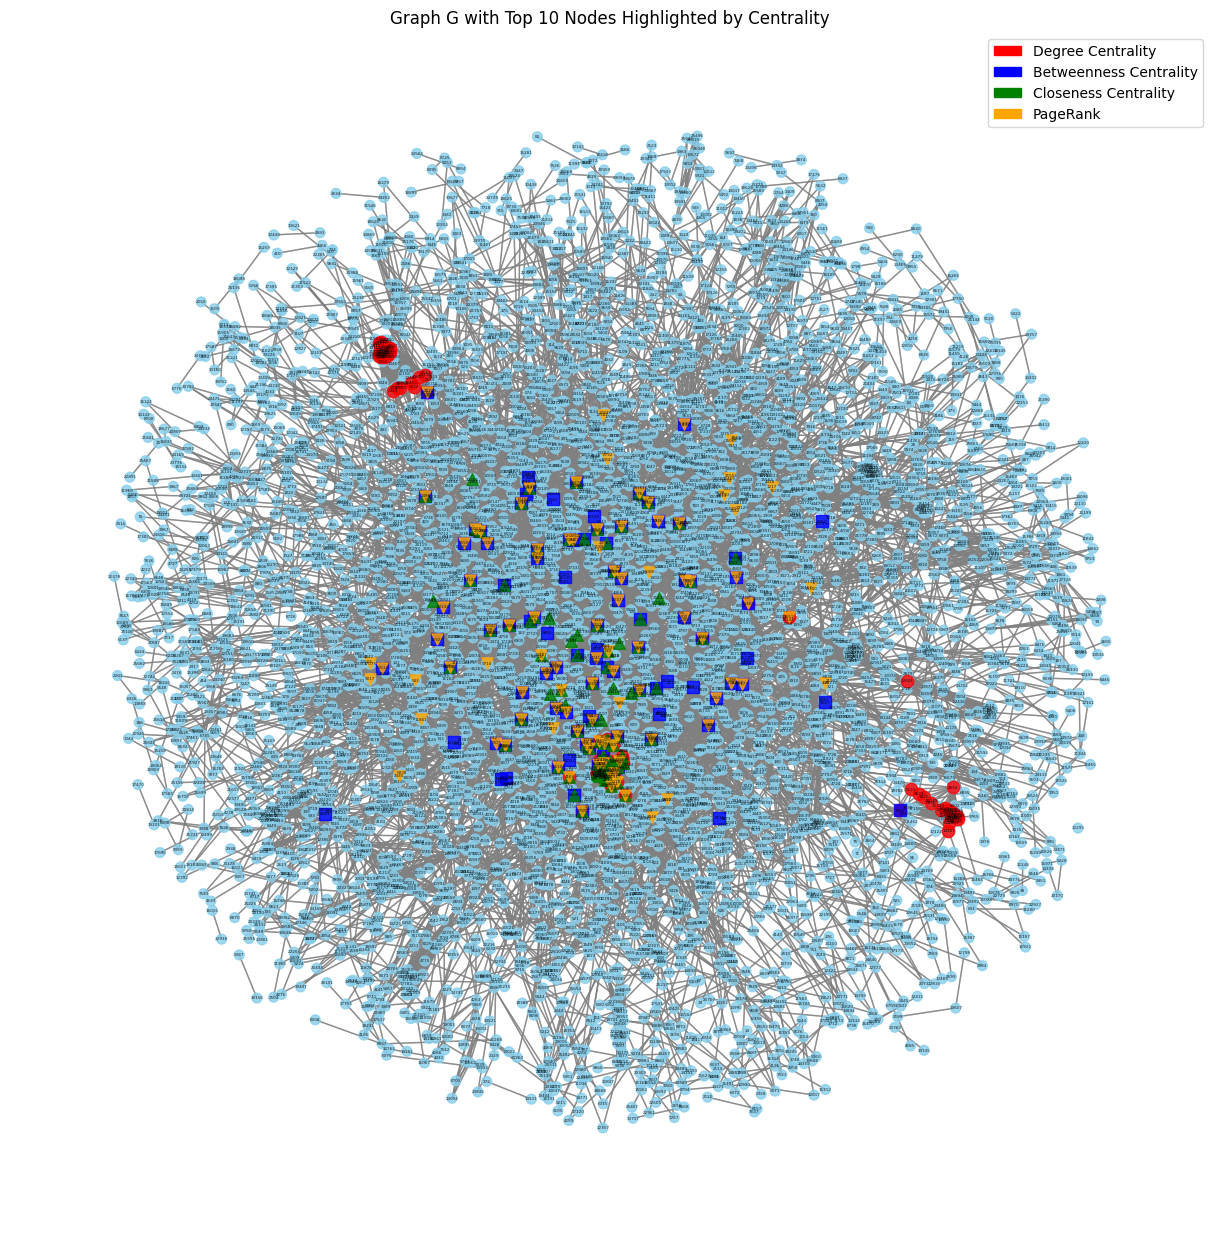

In [ ]:
# get the 100 smallest ranks
top_nodes = {
    'Degree Centrality': centrality_df.nsmallest(100, 'Degree Centrality Rank')['Node'].tolist(),
    'Betweenness Centrality': centrality_df.nsmallest(100, 'Betweenness Centrality Rank')['Node'].tolist(),
    'Closeness Centrality': centrality_df.nsmallest(100, 'Closeness Centrality Rank')['Node'].tolist(),
    'PageRank': centrality_df.nsmallest(100, 'PageRank Rank')['Node'].tolist(),
}

# assign colors
colors = {
    'Degree Centrality': 'red',
    'Betweenness Centrality': 'blue',
    'Closeness Centrality': 'green',
    'PageRank': 'orange',
}

# assign symbols
markers = {
    'Degree Centrality': 'o',  # cirle
    'Betweenness Centrality': 's',  # square
    'Closeness Centrality': '^',  # triangle
    'PageRank': 'v',  # inverted triangle
}

# assign sizes
sizes = {
    'Degree Centrality': NODE_SIZE * 1.6,
    'Betweenness Centrality': NODE_SIZE * 1.5,
    'Closeness Centrality': NODE_SIZE * 1.4,
    'PageRank': NODE_SIZE * 1.3,
}


# initialize node colors, shapes and sizes 
node_colors = [NODE_COLOR_STANDARD] * G.number_of_nodes()
node_shapes = ['o'] * G.number_of_nodes()
node_sizes = [NODE_SIZE] * G.number_of_nodes()

# assign colors, sizes and shapes to nodes
for centrality, nodes in top_nodes.items():
    for node in nodes:
        idx = list(G.nodes).index(node)
        node_colors[idx] = colors[centrality]
        node_shapes[idx] = markers[centrality]
        node_sizes[idx] = sizes[centrality] 

# draw graph
plt.figure(figsize=(12, 12))
pos = get_pos(G)

nx.draw(G, pos, with_labels=True, node_color=NODE_COLOR_STANDARD, node_size=node_sizes, edge_color=EDGE_COLOR_STANDARD, font_size=FONT_SIZE, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=EDGE_COLOR_STANDARD)

# draw nodes with respect of their centrality
for centrality, nodes in top_nodes.items():
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors[centrality], node_shape=markers[centrality], node_size=sizes[centrality], label=centrality, alpha=0.8)


plt.title("Graph G with Top 100 Nodes Highlighted by Centrality")
legend_handles = [mpatches.Patch(color=color, label=centrality) for centrality, color in colors.items()]
plt.legend(handles=legend_handles, loc='best')
plt.show()

# Task 6 – Node Roles: 


In this task, we aim to determine the roles of nodes within this graph by calculating the **rawComm** metric wich was introduced in this [paper](https://www.researchgate.net/publication/228665526_Node_roles_and_community_structure_in_networks).

This metrics estimates the number of communities a given node is associated with in a network. A higher *rawComm* value means that this node interacts with multiple commmunites in the network.

rawComm metric is defined as:

$$
\text{rawComm}(u) = \sum_{v \in N(u)} \tau_u(v)
$$

where:

$$
\tau_u(v) = \frac{1}{1 + p \cdot |N(u) \cap N(v)| + (1 - q) \cdot |N(u) \setminus (N(v) \cup \{v\})|}
$$

with:

- **${rawComm}(u)$:**  
  Estimated measure of the number of communities to which node $u$ belongs.

- **$N(u)$:**  
  The neighborhood of $u$, i.e., the set of all nodes directly linked to $u$.

- **$\tau_u(v)$:**  
  The contribution of node $v$ to $u$'s $\text{rawComm}$ score. It depends on the overlap between the neighborhoods of $u$ and $v$.

- **$p$:**  
  The probability that an edge connects two nodes in the same community.

- **$q$:**  
  The probability that two unconnected nodes belong to different communities.

- **$|N(u) \cap N(v)|$:**  
  The number of shared neighbors between nodes $u$ and $v$. This measures how much $u$ and $v$ belong to the same local community.

- **$|N(u) \setminus (N(v) \cup \{v\})|$:**  
  The number of neighbors of $u$ that are not part of $v$'s neighborhood or $v$ itself. This accounts for potential separate communities linked by $u$.


To calculate the the parameters $p$ and $q$ we use the louvain communities with `detect_communities()` and then calculate the probability $q$ and $p$ in `calculate_p_q()`. To calculate $p$ and $q$ it is nececarry to estimate communites. By estimating the communities, we are assuming that those communities are the real communities, to get an approximate value for the parameters. 


In [18]:

# Detect communities in the graph
def detect_communities(graph):
    
    
    # Check for connected components
    if nx.is_connected(graph):
        partition = community_louvain.best_partition(graph)
    else:
        # If the graph is not connected, compute partitions for each component
        partition = {}
        for component in nx.connected_components(graph):
            subgraph = graph.subgraph(component)
            sub_partition = community_louvain.best_partition(subgraph)
            partition.update(sub_partition)
    
    return partition


In [19]:
def calculate_p_q(G):
    # Detect communities
    partition = community_louvain.best_partition(G)  # Returns {node: community_id}
    
    # Create a mapping of communities
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    # Calculate p
    same_community_edges = 0
    for u, v in G.edges():
        if partition[u] == partition[v]:  # Same community
            same_community_edges += 1
    
    total_edges = G.number_of_edges()
    p = same_community_edges / total_edges if total_edges > 0 else 0
    
    # Calculate q
    unconnected_pairs_diff_communities = 0
    total_unconnected_pairs = 0
    
    # All node pairs
    all_nodes = list(G.nodes())
    for u, v in combinations(all_nodes, 2):
        if not G.has_edge(u, v):  # Only consider unconnected pairs
            total_unconnected_pairs += 1
            if partition[u] != partition[v]:  # Different communities
                unconnected_pairs_diff_communities += 1
    
    q = (unconnected_pairs_diff_communities / total_unconnected_pairs) if total_unconnected_pairs > 0 else 0
    
    return p, q

In [20]:
# Detect communities
partition = detect_communities(G)

# Calculate p and q
p, q = calculate_p_q(G)

print(f"p (intra-community edge probability): {p}")
print(f"q (unconnected inter-community probability): {q}")

p (intra-community edge probability): 0.9027202430267882
q (unconnected inter-community probability): 0.9755414902460448


In [21]:
def compute_raw_comm_u(graph, u, p=1, q=1):
    neighbors_u = set(graph.neighbors(u))
    raw_comm = 0.0
    
    for v in neighbors_u:
        neighbors_v = set(graph.neighbors(v))
        
        # Compute intersection and difference sizes
        common_neighbors = len(neighbors_u & neighbors_v)
        unique_neighbors = len(neighbors_u - (neighbors_v | {v}))
        
        # Compute tau_u(v)
        tau_uv = 1 / (1 + p * common_neighbors + (1 - q) * unique_neighbors)
        raw_comm += tau_uv
    
    return raw_comm

After calculating the *rawComm* for each node, we use `MinMax-Scaling` as introduced in [paper](https://www.researchgate.net/publication/228665526_Node_roles_and_community_structure_in_networks) to assign the roles to the nodes. 

We compare the scaled degree centrality (y-axis) with the scaled *rawComm* (x-axis). 
By setting the treshold to 0.5 we assign the roles to the nodes. 

The roles can be determined by dividing the community-degree chart into four quadrants, each representing a distinct role as introduced in the paper.  

- **Ambassadors** occupy the upper-right quadrant, characterized by both a high degree and a high community score. These nodes connect to many different communities, acting as key intermediaries.  

- The upper-left quadrant represents **big fish**, which have a high degree but a low community score. These nodes are highly connected within a single community, making them significant only in their local context.  

- **Bridges** are found in the lower-right quadrant, with a low degree but a high community score. These nodes connect a few communities, serving as critical links between otherwise disconnected groups.  

- Finally, the lower-left quadrant is home to **loners**, nodes with both a low degree and a low community score. These nodes have minimal influence and limited connections within the network.

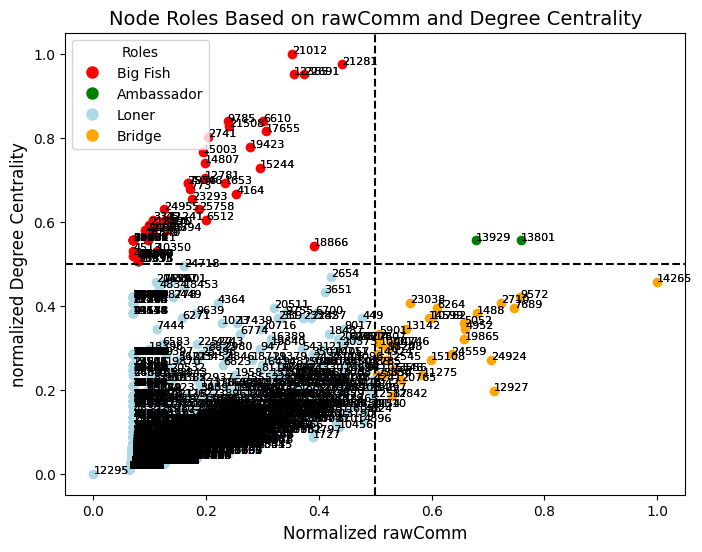

In [42]:
def scale_data(data):
    data = np.array(data)
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_data = normalized_data.flatten()
    return normalized_data


# Compute scores
raw_comm_values = {u: compute_raw_comm_u(G, u, p, q) for u in G.nodes()}

# get the degree centralities
degree_centrality = nx.degree_centrality(G)

# Extract values
rawComm_vals = list(raw_comm_values.values())
degree_vals = [degree_centrality[node] for node in G.nodes]

# scale the values with Min Max scaler
rawComm_tf = scale_data(rawComm_vals)
degree_tf = scale_data(degree_vals)

# assign roles to nodes with treshold of 0.5
treshold = 0.5
roles = {}
for i, node in enumerate(G.nodes):
    if degree_tf[i] <= treshold and rawComm_tf[i] <= treshold:
        roles[node] = 'Loner'
    elif degree_tf[i] >= treshold and rawComm_tf[i] <= treshold:
        roles[node] = 'Big Fish'
    elif degree_tf[i] <= treshold and rawComm_tf[i] >= treshold:
        roles[node] = 'Bridge'
    elif degree_tf[i] >= treshold and rawComm_tf[i] >= treshold:
        roles[node] = 'Ambassador'

# Plot the diagram
plt.figure(figsize=(8, 6))
colors = {'Big Fish': 'red', 'Ambassador': 'green', 'Loner': 'lightblue', 'Bridge': 'orange'}
texts = []
for i, node in enumerate(G.nodes):
    plt.scatter(rawComm_tf[i], degree_tf[i], color=colors[roles[node]], label=roles[node])
    plt.text(rawComm_tf[i], degree_tf[i], s=node, fontsize=8)
    texts.append(plt.text(rawComm_tf[i], degree_tf[i], s=node, fontsize=8))

# Add dividing lines
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')

# Customize plot
plt.xlabel(xlabel="Normalized rawComm", fontsize=12)
plt.ylabel(ylabel="Normalized Degree Centrality", fontsize=12)
plt.title(label="Node Roles Based on rawComm and Degree Centrality", fontsize=14)

# Add legend
handles = [plt.Line2D(xdata=[0], ydata=[0], marker='o', color='w', label=role, markerfacecolor=color, markersize=10) 
           for role, color in colors.items()]
plt.legend(handles=handles, title="Roles", loc='upper right')
plt.show()


<Figure size 1200x1200 with 0 Axes>

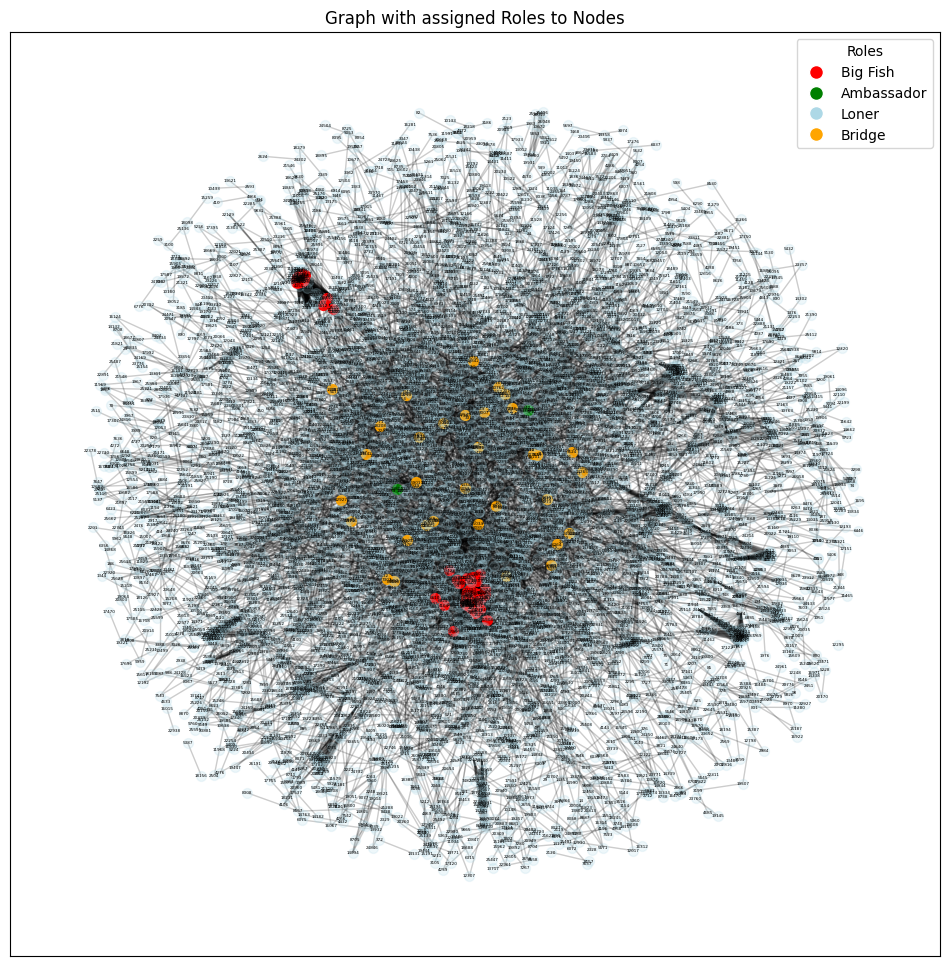

In [43]:
# Plot the diagram
plt.figure(figsize=(12, 12))
colors = {'Big Fish': 'red', 'Ambassador': 'green', 'Loner': 'lightblue', 'Bridge': 'orange'}


# Define alpha values for roles
node_colors = [colors[roles[node]] for node in G.nodes()]
node_alphas = [0.2 if roles[node] == 'Loner' else 0.9 for node in G.nodes()]

pos = get_pos(G)

# Plot the graph
plt.figure(figsize=(12, 12))
for node, alpha in zip(G.nodes(), node_alphas):
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=colors[roles[node]], alpha=alpha, node_size=NODE_SIZE)

nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=FONT_SIZE)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=role) 
           for role, color in colors.items()]
plt.legend(handles=handles, title="Roles", loc='upper right')
plt.title("Graph with assigned Roles to Nodes")
plt.show();

In [157]:
df_roles = pd.DataFrame([roles]).T.reset_index().rename(columns={0: 'role', 'index': 'node'})

def display_roles(role):
    df_display = df_roles.loc[df_roles['role'] == role]
    print(f'Number of Nodes assgned to role "{role}", {df_display.shape[0]}')
    display(df_display)

for role in df_roles.role.unique():
    display_roles(role)

Number of Nodes assgned to role "Loner", 5136


node   role
0      3466  Loner
1       937  Loner
2      5233  Loner
3      8579  Loner
4     10310  Loner
...     ...    ...
5237     14  Loner
5238  14171  Loner
5239  14845  Loner
5240   5232  Loner
5241  19521  Loner

[5136 rows x 2 columns]

Number of Nodes assgned to role "Bridge", 33


node    role
11     9572  Bridge
20     5052  Bridge
27     5346  Bridge
31     9124  Bridge
45    24559  Bridge
53     7689  Bridge
108   14265  Bridge
123    7350  Bridge
146   13556  Bridge
186    2710  Bridge
207   14599  Bridge
315   24924  Bridge
346   23038  Bridge
363    1488  Bridge
365   10762  Bridge
369   13142  Bridge
370   15108  Bridge
396    7007  Bridge
457    7307  Bridge
465   14746  Bridge
543   18208  Bridge
746   14924  Bridge
968   25034  Bridge
1011  11275  Bridge
1032   4952  Bridge
1066   1000  Bridge
1088  19865  Bridge
1091   5901  Bridge
1137  12842  Bridge
1515  12545  Bridge
1731  12927  Bridge
1733   6264  Bridge
2138  20765  Bridge

Number of Nodes assgned to role "Big Fish", 71


node      role
72     6610  Big Fish
77     9785  Big Fish
100   19423  Big Fish
101   21012  Big Fish
103   22691  Big Fish
...     ...       ...
1289  17807  Big Fish
1290  18225  Big Fish
1295  19645  Big Fish
1296  19939  Big Fish
1298  20576  Big Fish

[71 rows x 2 columns]

Number of Nodes assgned to role "Ambassador", 2


node        role
577   13929  Ambassador
1037  13801  Ambassador

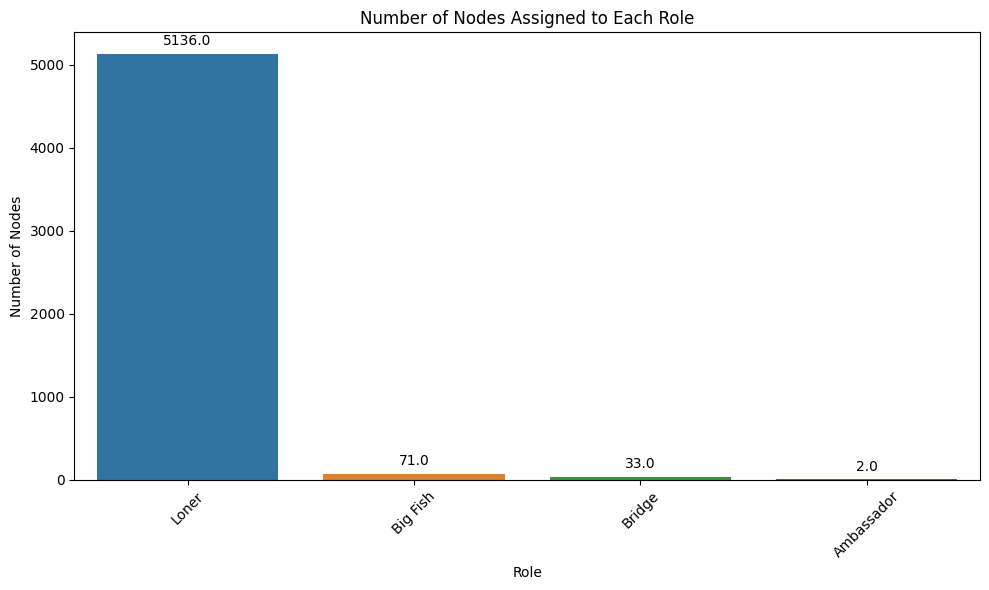

In [176]:
# Count the nodes for each role
role_counts = df_roles['role'].value_counts()

# Create a color list based on the custom colors dictionary
bar_colors = [colors[role] for role in role_counts.index]

# Plotting the barplot for role counts with custom colors
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=role_counts.index, y=role_counts.values, hue=bar_colors)
plt.title('Number of Nodes Assigned to Each Role')
plt.xlabel('Role')
plt.ylabel('Number of Nodes')
plt.xticks(rotation=45)
plt.legend().set_visible(False)

# Zahlen zu den Balken hinzufügen
for p in ax.patches:
    if p.xy != (0, 0):
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

### Observation:

In this network, we observe the following distribution of roles:

- **Loner**: 5136 nodes (large majority)
- **Bridge**: 33 nodes
- **Big Fish**: 71 nodes
- **Ambassador**: 2 nodes

### Role Descriptions:

- **Big Fish**: These are nodes with significant influence within the network, often connecting to many other nodes. They play a key role in driving the flow of information or resources across the network and attract numerous connections, making them central figures in the structure.

- **Ambassador**: These nodes act as intermediaries between different groups or communities within the network. They facilitate communication and interactions, ensuring that information flows smoothly across boundaries, and typically hold a connecting position between otherwise distinct clusters.

- **Bridge**: Bridges are nodes that serve as facilitators of cooperation between distinct parts of the network. They manage the flow of information between different subgroups, playing an essential role in enabling collaboration and ensuring that isolated sections of the network remain connected.

- **Loner**: These nodes operate at the periphery of the network, having few or no connections to other nodes. They are not highly integrated into the overall structure, indicating isolation or a lack of interaction with the main clusters of the network.

This distribution highlights the highly decentralized nature of the network, where the majority of nodes are isolated ("Loners"), while a small proportion play more active, central roles ("Big Fish," "Ambassadors," and "Bridges") to ensure connectivity and facilitate communication across the system.

</div>

# Task 7 – Community Discovery

There a several community clustering algorthms. Because the Girvan Newman Algorithm has a expensive runtime, we are introducing also the Label Propagation Algortihm in this Chapter.

**[Girvan Newman Algorithm:](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html)**

The Girvan-Newman algorithm identifies communities by looking for the most important edges in the network. It removes edges that are central to connecting different parts of the graph, assuming that removing these edges will cause the graph to break into distinct communities. This process is repeated until the graph is split into disconnected components, which are then considered as individual communities.


**[Louvain Algorithm:](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)**

The Louvain algorithm focuses on maximizing a measure called modularity, which quantifies how well the nodes within a community are connected compared to those outside it. The algorithm iteratively moves nodes between communities to improve this modularity. It then aggregates communities and repeats the process, ultimately finding a division that best represents the community structure of the graph.

**[Label Propagation Algorithm:](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html#id1)**

The Label Propagation algorithm assignes nodes in the graph to inital unique labels. Over time, nodes adopt the most common label from their neighbors, essentially "propagating" community membership through the network. The algorithm stops once the labels stabilize and no further changes occur, resulting in the communities formed by the consensus of neighbors.


In [141]:
def generate_colors(num_colors):
    colors = plt.cm.get_cmap('hsv', num_colors)
    return [colors(i) for i in range(num_colors)]

def plot_cluster(G, clusters, title):

    num_clusters = len(clusters)
    colors = generate_colors(num_colors=num_clusters)

    print(f'Number of Clusters: {num_clusters}')

    # Knotenfarben basierend auf den Clustern zuweisen
    node_colors = []
    for node in G.nodes():
        for i, cluster in enumerate(clusters):
            if node in cluster:
                node_colors.append(colors[i % len(colors)])

    # Netzwerk zeichnen
    plt.figure(figsize=(12, 12))
    pos = get_pos(G)

    fig = nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=NODE_SIZE, font_size=FONT_SIZE)
    plt.title(title)
    plt.show()

    return None

In [ ]:
# Detect communities using label propagation
label_propagation_clusters = nx.algorithms.community.label_propagation_communities(G)

# Convert to list of communities
label_propagation_clusters = [list(c) for c in label_propagation_clusters]
print(f'Number of cluster assignments: {len(label_propagation_clusters)}')


Number of cluster assignments: 1015


In [ ]:
# First Layer of grivan newman algorithm
girvan_newman = nx.algorithms.community.centrality.girvan_newman(G)
j = 1
for i, communities in enumerate(girvan_newman):
    if i == j:
        print('Communities:', len(communities))
        gn_clusters = tuple(set(sorted(c)) for c in communities)
        print(gn_clusters)
        break
    

Communities: 357
({8193, 24578, 8195, 16389, 8198, 24582, 8200, 16393, 24583, 24587, 24589, 8206, 8208, 24592, 24593, 8211, 24595, 22, 8215, 24, 8216, 26, 27, 8219, 29, 8222, 16414, 8224, 16415, 24601, 24614, 8231, 24616, 24617, 24620, 45, 46, 16429, 16433, 62, 8254, 65, 8261, 70, 71, 75, 78, 80, 81, 16469, 8279, 88, 8280, 8282, 16471, 16475, 93, 95, 16482, 16483, 16485, 16486, 106, 8298, 8299, 8301, 16495, 16496, 113, 114, 8305, 16498, 8310, 8312, 16505, 122, 123, 124, 16506, 24696, 16511, 128, 16513, 24699, 24705, 24706, 135, 16521, 24713, 140, 141, 24718, 8335, 24722, 8340, 24726, 24731, 24734, 16543, 8352, 16545, 163, 164, 165, 16553, 16554, 8365, 8367, 8369, 178, 179, 16563, 16565, 8374, 183, 8375, 185, 8376, 8378, 16568, 16570, 24762, 16575, 192, 193, 8386, 195, 8387, 197, 16576, 199, 200, 8391, 16584, 205, 8398, 16589, 16590, 24781, 16594, 8403, 214, 215, 8408, 16598, 16607, 16608, 16611, 231, 232, 238, 24814, 16624, 24819, 244, 245, 8437, 8441, 8442, 252, 253, 8446, 16640, 8449

In [ ]:
louvain_cluster = nx.algorithms.community.louvain_communities(G, seed=42, resolution=1)
print(f'Number of cluster assignments: {len(louvain_cluster)}')

[{6913, 23298, 22275, 5634, 2566, 17161, 3593, 22285, 19219, 20243, 19223, 15384, 23066, 18972, 29, 17950, 1310, 4638, 16675, 14627, 17189, 17918, 20779, 25904, 25138, 15159, 21048, 19256, 17721, 13624, 24122, 18237, 25152, 25408, 12866, 17991, 25931, 2124, 1105, 18522, 11611, 4700, 3418, 23909, 10597, 16741, 1386, 3946, 2926, 16751, 16496, 6513, 11891, 887, 14967, 22393, 3449, 1403, 17017, 1658, 17275, 12157, 12158, 11903, 6023, 23945, 3721, 16779, 140, 4493, 9870, 14985, 24210, 23186, 20886, 17304, 4760, 21657, 18587, 24475, 2720, 9634, 930, 9124, 18597, 14500, 18600, 23720, 3754, 12971, 15786, 23214, 23986, 3765, 14781, 6078, 4798, 9408, 1985, 20421, 3526, 1738, 17612, 19404, 6864, 4822, 7645, 8185, 2783, 16607, 5346, 19682, 20196, 5606, 25321, 3821, 11502, 10478, 7926, 15353, 510}, {16470, 17822}, {13056, 3073, 19974, 23304, 17932, 11788, 18189, 14606, 21776, 3345, 12306, 12308, 13333, 3607, 2076, 10526, 20001, 12066, 15907, 15144, 15912, 12334, 26159, 11824, 1840, 3890, 24372, 218

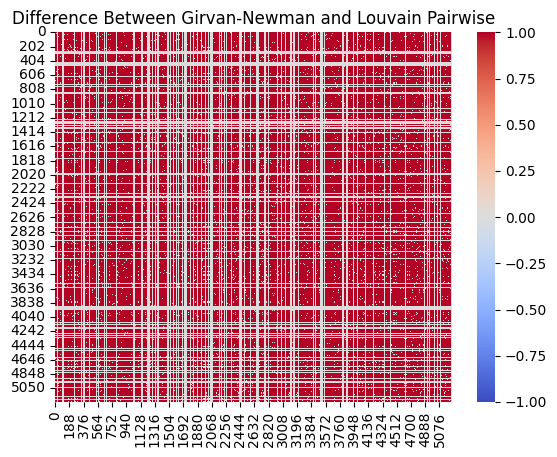

Fraction of Agreement: 0.42
Number of nodes assigned to different clusters: 4118 of 5242


In [ ]:

def create_pairwise_matrix(clusters):
    """Create a pairwise similarity matrix for nodes and their cluster assignments."""

    nodes = sorted({node for cluster in clusters for node in cluster})  # Unique sorted nodes

    node_index = {node: idx for idx, node in enumerate(nodes)}
    matrix = np.zeros((len(nodes), len(nodes)))

    for cluster in clusters:
        cluster_nodes = [node_index[node] for node in cluster]
        for i in cluster_nodes:
            for j in cluster_nodes:
                matrix[i, j] = 1
    #print(matrix)
    #print(f'Shape: {matrix.shape}')
    return matrix

#print("\nGirvan-Newman Pairwise Matrix:")
girvan_matrix = create_pairwise_matrix(gn_clusters)

#print("\nLouvain Pairwise Matrix:")
louvain_matrix = create_pairwise_matrix(louvain_cluster)

# Compute difference matrix
difference_matrix = girvan_matrix - louvain_matrix

# Plot heatmap
sns.heatmap(difference_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Difference Between Girvan-Newman and Louvain Pairwise")
plt.show()

agreement = np.mean(girvan_matrix == louvain_matrix)
print(f"Fraction of Agreement: {agreement:.2f}")

<div class="alert alert-block alert-info">

### Observation: Girvan-Newman vs Louvain

When comparing the Girvan-Newman and Louvain algorithms, we observe that 42% of nodes were assigned to the same cluster, while 58% were assigned to different clusters. This moderate level of disagreement can be attributed to the fact that we only examined the first layer of the hierarchical clusters produced by the Girvan-Newman algorithm, which divides the network based on edge betweenness. In contrast, the Louvain algorithm focuses on maximizing modularity, often leading to clusters of varying sizes and compositions.

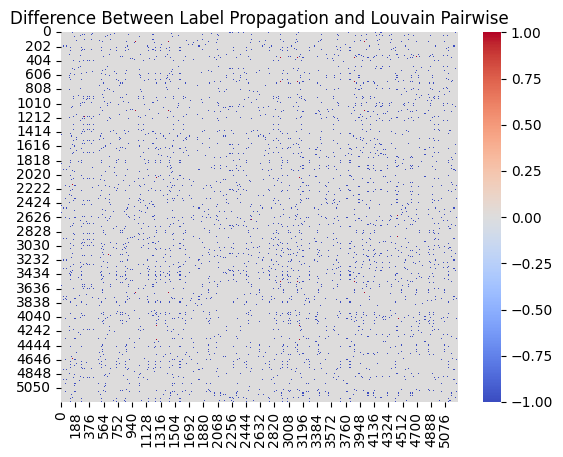

Fraction of Agreement: 0.98
Number of nodes assigned to different clusters: 4119 of 5242


In [154]:
# Create pairwise comparsin of label propagatiton 
label_prop_matrix = create_pairwise_matrix(label_propagation_clusters)

# Compute difference matrix
difference_matrix = label_prop_matrix - louvain_matrix

# Plot heatmap
sns.heatmap(difference_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Difference Between Label Propagation and Louvain Pairwise")
plt.show()

agreement = np.mean(label_prop_matrix == louvain_matrix)
print(f"Fraction of Agreement: {agreement:.2f}")

<div class="alert alert-block alert-info">

### Observation: Label-Propagation vs Louvain

The Fraction of Agreement between the Label-Propagation and Louvain algorithms is 0.98, indicating a very high level of similarity in the cluster assignments. This high agreement indicates that the Label-Propagation algorithm, which relies on node label propagation through the network, and the Louvain algorithm, which optimizes modularity, produce very similar cluster structures. The minor discrepancies observed (2% disagreement) might be attributed to the inherent randomness in the initialization of the Label-Propagation algorithm or subtle variations in the optimization of its objective function.Overall, the substantial Fraction of Agreement suggests that both algorithms have identified analogous community structures within the network.

Number of Clusters: 392


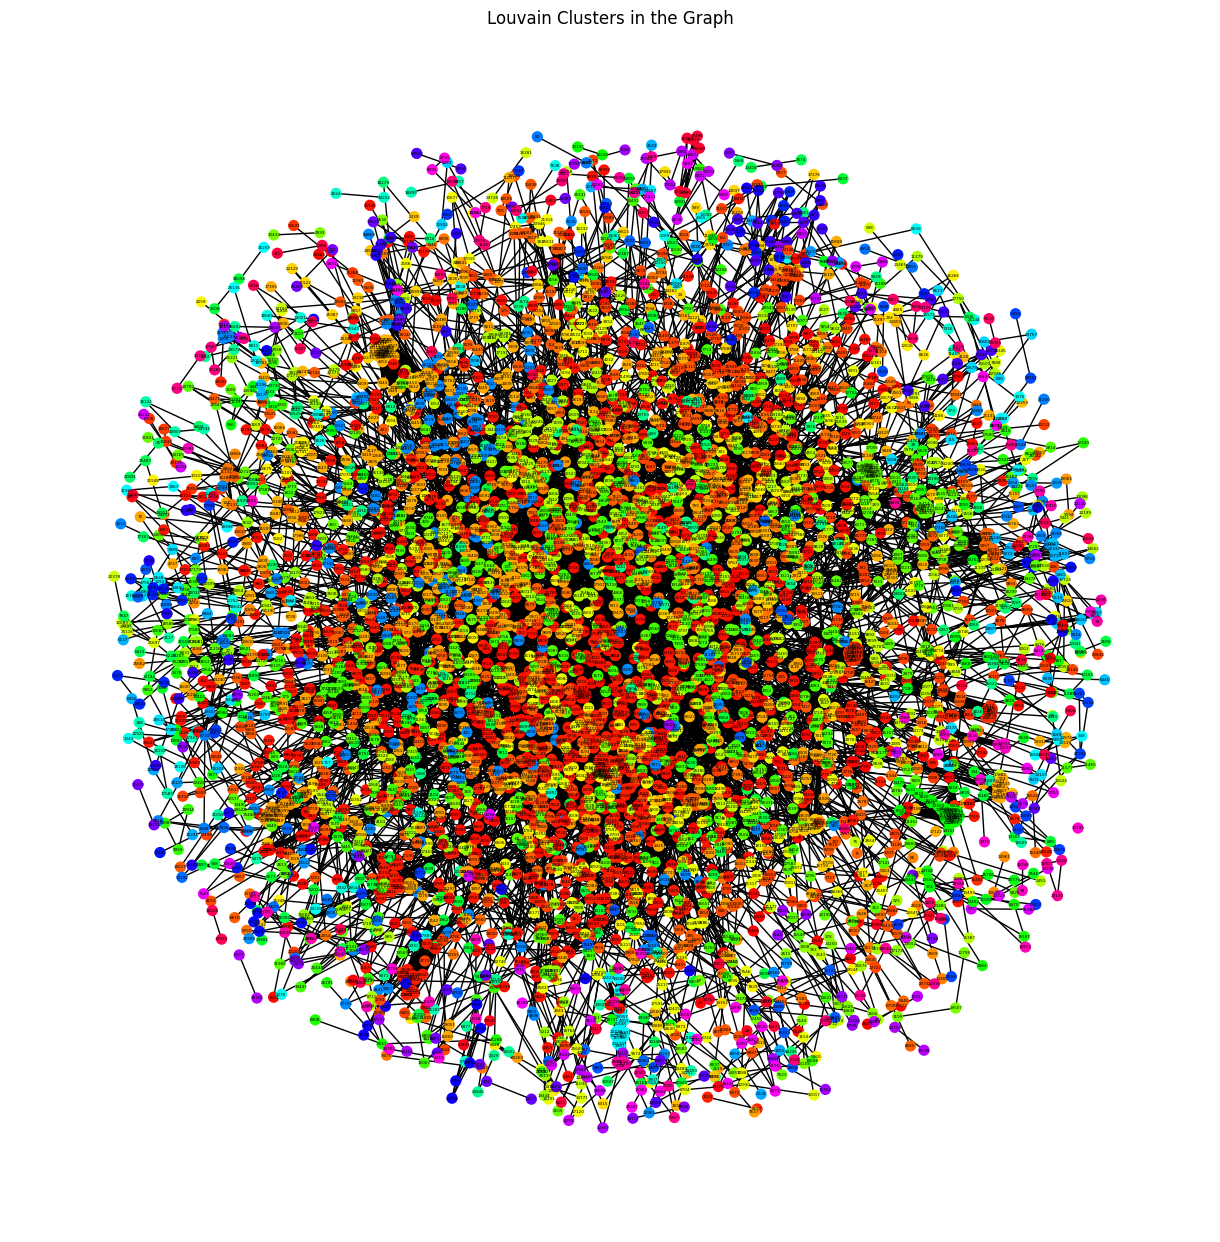

In [142]:
plot_cluster(G, louvain_cluster, title='Louvain Clusters in the Graph')

# Task 8 – Conclusions and Future Work